In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/


In [ ]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from termcolor import cprint
import tflite_runtime.interpreter as tflite

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

#Test on full network

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Barcelona	       Europass				     NN
'challenge 2.avi'     'Foglio di lavoro senza nome.gsheet'   ROC.gsheet
'Colab Notebooks'     'forces in fluids.gsheet'		     USB
'cours physique.zip'   kreisel.gsheet
 elasticity.gsheet    'Magn hysteresis.gsheet'


In [ ]:
data = np.load("/content/drive/My Drive/NN/data/testing_data.npy").astype(np.float32)

model_name = 'model_fc_1l_32'

loaded_events = data.shape[0]
n_samples = data.shape[1]
n_channels = data.shape[2]
#data = np.reshape(data, (loaded_events, -1))#reshape for fc network
#np.expand_dims(x, axis=-1) #for cnn network


# define labels with one hot encoding, (1,0) -> noise, (0,1) -> signal
test_label = np.zeros((loaded_events, 2))
test_label[:25000, 1] = 1
test_label[25000:, 0] = 1


tot_n = int(test_label[25000:,0].sum())
tot_s = int(test_label[:25000,1].sum())

print(data.shape, test_label.shape)

(950000, 256, 1) (950000, 2)


In [ ]:
model_float = keras.models.load_model(f'/content/drive/My Drive/NN/train_all/{model_name}.h5', compile=False)
y_pred = model_float.predict(np.reshape(data, (loaded_events, -1))) #for cnn network: np.expand_dims(data, axis=-1), fcn: np.reshape(data, (loaded_events, -1))

In [ ]:


#Try to make predictions for quantized model: TPU
data_q = np.zeros_like(data)
FCN = True

#Load model and set delegate

path_to_model = f'/content/drive/My Drive/NN/train_all/{model_name}_quantized.tflite'
interpreter = tflite.Interpreter(path_to_model)
interpreter.allocate_tensors()

# Get input tensor.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

input_index = input_details[0]["index"]
output_index = output_details[0]["index"]
print("Model loaded, input_shape:",input_shape)
print("\nInput details:", input_details)
print("\nOutput details:", output_details)


# Check if the input type is quantized, then rescale input data to uint8 - see https://www.tensorflow.org/lite/performance/post_training_integer_quant
if input_details[0]['dtype'] == np.int8:
  input_scale, input_zero_point = input_details[0]["quantization"]
  data_q = data / input_scale + input_zero_point
  print(data_q.shape)

if FCN: #infere all events at once for FCN
  data_q = np.reshape(data_q, (loaded_events, -1))
  data_q = np.array(data_q, dtype = input_details[0]["dtype"])
  interpreter.resize_tensor_input(0, [loaded_events, n_samples])   #cnn: [1, n_samples, 1], fc: [loaded_events, n_samples]
  interpreter.allocate_tensors()
  interpreter.set_tensor(input_index, data_q)
  predictions = interpreter.tensor(output_index)
  interpreter.invoke()
  y_quant = input_scale*(predictions() - input_zero_point)
  predictions = predictions()

else:
  data_q = np.expand_dims(data_q, axis=0) #activate for cnn
  data_q = np.array(data_q, dtype = input_details[0]["dtype"])
  
  print(data.shape)
  print(data_q.shape)
  
  predictions = np.zeros_like(test_label)
  y_quant = np.zeros_like(test_label)

  for i in range(loaded_events):     
      if i%100000 == 0:
        print(f"Event {i}/{loaded_events}...")

      event_i = data_q[:, i, :, :]  # ---> change this for conv network; add [:, i, :, :]
    

      interpreter.set_tensor(input_details[0]['index'], event_i)
      interpreter.invoke()
      pred = interpreter.get_tensor(output_details[0]['index'])
      predictions[i,:] = pred
      y_quant[i,:] = input_scale*(pred - input_zero_point)

print(predictions)
print(y_quant)






##p.save(f'{plots_dir}/{model_name}_inference_{form}_{chip}_times_log.npy', times_mean)
#np.save(f'{plots_dir}/{model_name}_inference_{form}_{chip}_std_log.npy', times_std)

cprint("Inference test for Convolutional Network done!", "green")

Model loaded, input_shape: [  1 256]

Input details: [{'name': 'layer1_input_int8', 'index': 0, 'shape': array([  1, 256], dtype=int32), 'shape_signature': array([ -1, 256], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0007842584163881838, 0), 'quantization_parameters': {'scales': array([0.00078426], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Output details: [{'name': 'Identity_int8', 'index': 7, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
(950000, 256, 1)
[[-128  127]
 [-128  127]
 [-128  127]
 ...
 [ 127 -128]
 [ 127 -128]
 [ 127 -128]]
[[-0.10038508  0.09960082]
 [-0.10038508  0.09960082]
 [-0.10038508  0.09960082]
 ...


In [ ]:
print(predictions[30000:30200,0])
print(y_quant[0,1])

[127 127 127 127 127 127 127 127 127 127 127 109 127 124 127 127 127 127
 126 126 127 127 127 127 125 127 127 127 126 127 127 127 127 127 127 127
 127 127 127 127 127 127 127 127 127 127  92 127 127 127  98 127 127 127
 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
 127 127 127 127 127 127 127 127 127 127 126 127 120 127 127 127 127 127
 127 127 127 127 127 127 126 127 127 127 127 127 127 127 127 127 127 127
 127 127 127 127 127 127 127 127 127 127 127 126 127 127 126 127 123 119
 127 127 127 127 127 127 127 115 127 127 127  64 127 127 127 127 127 127
 127 127 127 127 127 127 127 127 126 125 127 127 127 127 127 127 127 127
 121 127 127 121 127 127 127 127 127 127 127 127 127 127 127 127 127 126
 127 127 127 127 127 126 127 126 127 127 115 127 127 127 127 127 127 127
 127 127]
0.09960081888129935


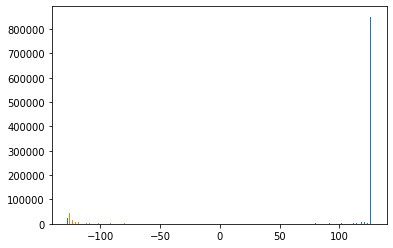

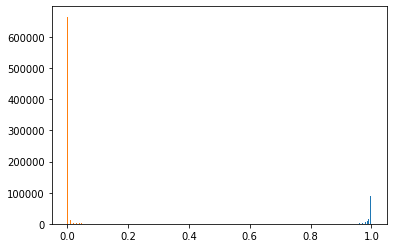

In [ ]:
plt.hist(predictions, 200)
#plt.xlim(-128, -127.9)
plt.show()

plt.hist(y_pred, 500)
#plt.xlim(0, 0.015)
plt.show()

In [ ]:
# Compare prediction results with ground truth labels to calculate accuracy.
#Accuracy float - model
accurate_count_float = 0
for index in range(loaded_events):
  digit = np.argmax(y_pred[index])
  if digit == test_label[index,1]:
    accurate_count_float += 1
 
accuracy_float = accurate_count_float * 1.0 / loaded_events

print(accuracy_float)

0.9973221052631579


In [ ]:
# Compare prediction results with ground truth labels to calculate accuracy.
accurate_count = 0
for index in range(loaded_events):
  digit = np.argmax(predictions[index,:])
  
  if digit == test_label[index,1]:
    accurate_count += 1
  #else:
   # print(predictions()[index,:], y_quant[index,:])
accuracy = accurate_count * 1.0 / loaded_events

print(accuracy)

0.9981926315789473


In [ ]:
yy = np.log10(np.linspace(10 ** 0.000001, 10 ** 0.999999, 10000))
#yy_q = yy / input_scale + input_zero_point
yy_q = np.linspace(-128, 127, 10000)

n = np.zeros_like(yy)
s = np.zeros_like(yy)

n_q = np.zeros_like(yy_q)
s_q = np.zeros_like(yy_q)

In [ ]:

for iT, threshold in enumerate(yy):
    eff_signal = np.sum((y_pred[:25000, 1] > threshold) == True) / tot_s
    s[iT] = eff_signal
    eff_noise = np.sum((y_pred[25000:, 1] > threshold) == False) / tot_n
    if (eff_noise < 1):
        reduction_factor = np.log10(1 / (1 - eff_noise))
    else:
        reduction_factor = np.log10(tot_n)
    n[iT] = 10 ** reduction_factor


In [ ]:
#Find neutrino rejection factor at 10^5:
iter = 0

while n[iter] < 10**5:
  iter = iter + 1

print(f'Noise rejection factor at 10⁵ (10e({np.log10(n[iter])})) = {s[iter]*100}%')

Noise rejection factor at 10⁵ (10e(5.011899223301952)) = 95.08%


In [ ]:
print(n)

[1.00000000e+00 1.59552081e+00 2.16700714e+00 ... 4.62500000e+05
 9.25000000e+05 9.25000000e+05]


In [ ]:

for iT, threshold in enumerate(yy_q):
    eff_signal = np.sum((predictions[:25000, 1] > threshold) == True) / tot_s
    s_q[iT] = eff_signal
    eff_noise = np.sum((predictions[25000:, 1] > threshold) == False) / tot_n
    if (eff_noise < 1):
        reduction_factor = np.log10(1 / (1 - eff_noise))
    else:
        reduction_factor = np.log10(tot_n)
    n_q[iT] = 10 ** reduction_factor


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

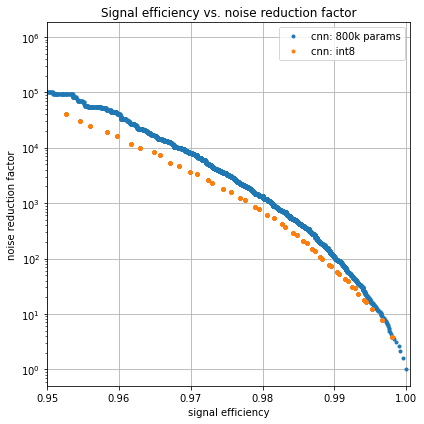

In [ ]:
xmin = 0.95
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(s, n, '.', label='cnn: 800k params')
ax.plot(s_q, n_q, '.',  label='cnn: int8')
ax.set_xlabel("signal efficiency")
ax.set_ylabel("noise reduction factor")
ax.set_title('Signal efficiency vs. noise reduction factor')
plt.xlim(xmin, 1.0005)
#plt.ylim(10**(-0.1), 10**5.5)
ax.semilogy(True)
ax.grid(True)
ax.legend()
fig.tight_layout()
fig.savefig(f"{model_name}_int_vs_flops_{xmin}.png", bbox_inches="tight", dpi=150)
files.download(f"{model_name}_int_vs_flops_{xmin}.png")
plt.show()